# Exploring Ensemble Methods

 We will use the pre-implemented gradient boosted trees in GraphLab Create. 

* Use SFrames to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.


In [1]:
import graphlab

# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 


In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1473103121.log


This non-commercial license of GraphLab Create for academic use is assigned to aguha2@jhu.edu and will expire on February 11, 2017.


## Modifying the target column



* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [3]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. 

The features we will be using are described in the code comments below:

In [4]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values



In [5]:
loans, loans_with_na = loans[[target] + features].dropna_split()

# Count the number of rows with missing data
num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()
print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)

Dropping 29 observations; keeping 122578 


## Make sure the classes are balanced

In [6]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]
print(len(safe_loans_raw))
print(len(risky_loans_raw))

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

99431
23147
Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


**Checkpoint:** we should now see that the dataset is balanced (approximately 50-50 safe vs risky loans).

## Split data into training and validation sets

In [7]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

# Gradient boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

**Additional reading:** 
* [GraphLab Create user guide](https://dato.com/learn/userguide/supervised-learning/boosted_trees_classifier.html)
* [Advanced material on boosted trees](http://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)


We will now train models to predict `safe_loans` using the features above.

In [8]:
model_5 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.094034     | 0.657541          | 0.657139          |

| 2         | 0.146533     | 0.656976          | 0.636157          |

| 3         | 0.207358     | 0.664983          | 0.623206          |

| 4         | 0.257741     | 0.668476          | 0.613783          |

| 5         | 0.311450     | 0.673339          | 0.606229          |

+-----------+--------------+-------------------+-------------------+

# Making predictions

* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [10]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
#sample_validation_data

### Predicting on sample validation data



In [12]:
y_hat=[]
for row in sample_validation_data:
    #print row
    y_hat.append(model_5.predict(row))
    predict= model_5.predict(row)
    #print(predict)
    
#print(y_hat)


### Prediction probabilities


In [14]:
y_hat=[]
for row in sample_validation_data:
    #print row
    y_hat.append(model_5.predict(row))
    predict= model_5.predict(row, output_type='probability' )
    #print(predict)
    
#print(y_hat)

## Evaluating the model on the validation data


$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$



In [15]:
accuracy = model_5.evaluate(validation_data)

print(accuracy)

{'f1_score': 0.6715001599317625, 'auc': 0.7247215702188436, 'recall': 0.6827840416305291, 'precision': 0.6605831760016782, 'log_loss': 0.617613176969398, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+-----+-----+------+------+
| threshold | fpr | tpr |  p   |  n   |
+-----------+-----+-----+------+------+
|    0.0    | 1.0 | 1.0 | 4612 | 4672 |
|   1e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   2e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   3e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   4e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   5e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   6e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   7e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   8e-05   | 1.0 | 1.0 | 4612 | 4672 |
|   9e-05   | 1.0 | 1.0 | 4612 | 4672 |
+-----------+-----+-----+------+------+
[100001 rows x 5 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'confusion_matrix': Columns:
	targe

## Comparison with decision trees

In the earlier analyis, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). here, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.


## Most positive & negative loans.


* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.


In [20]:
sample_validation_data['predictions'] = model_5.predict(sample_validation_data, output_type='probability' )


In [21]:
sample_validation_data.sort('predictions', ascending = False)

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	predictions	float

Rows: 4

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   B   |      0.2      |     0     |       3        |    MORTGAGE    |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
|     1      |   B   |      0.6      |     1     |       1        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.44 |    credit_card     |      6.30496      |      0      |        1         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
| 12.19 |    credit_card     |      13.4952      |      0      |        1         |
| 13.97 |       other        |      2.96736      |      3      |        0         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        1         |           1           |    8     |    0    |
|       0        |        1         |           1           |    17    |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    93.9    |        0.0         |   9.91   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
|      1       |    59.1    |        0.0         |  11.71   | ... |
|      1       |    59.5    |        0.0         |  16.77   | ... |
+--------------+------------+--------------------+----------+-----+
[4 rows x 26 columns]

In [22]:
validation_data['predictions'] = model_5.predict(validation_data, output_type='probability' )

In [23]:
print "Your loans      : %s\n" % validation_data['predictions'].head(4)
print "Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325]

Your loans      : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [24]:
validation_data[0:5]

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float
	predictions	float

Rows: 5

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
|     -1     |   F   |      0.4      |     0     |       5        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       11       |      RENT      |
|     -1     |   B   |      0.2      |     0     |       3        |      RENT      |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 13.97 |       other        |      2.96736      |      3      |        0         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
| 12.48 |   small_business   |      3.57024      |      0      |        1         |
| 23.18 | debt_consolidation |      14.7009      |      0      |        1         |
|  7.83 | debt_consolidation |      11.0486      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    17    |    0    |
|       3        |        1         |           1           |    6     |    0    |
|       0        |        1         |           1           |    6     |    0    |
|       2        |        1         |           1           |    8     |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    59.5    |        0.0         |  16.77   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
|      1       |    73.9    |        0.0         |  21.28   | ... |
|      1       |    79.7    |        0.0         |  16.77   | ... |
|      1       |    65.4    |        0.0         |   9.91   | ... |
+--------------+------------+--------------------+----------+-----+
[5 rows x 26 columns]

In [25]:
validation_data.sort('predictions', ascending = False)

safe_loans,grade,sub_grade_num,short_emp,emp_length_num,home_ownership,dti,purpose,payment_inc_ratio
1,A,0.2,0,11,MORTGAGE,4.21,credit_card,0.955726
1,A,0.4,0,4,MORTGAGE,12.76,car,1.7376
1,A,0.2,0,6,MORTGAGE,10.29,home_improvement,3.22264
1,A,0.2,0,8,MORTGAGE,10.02,wedding,3.49357
1,A,0.6,0,6,MORTGAGE,3.16,home_improvement,2.91713
1,A,0.6,0,5,MORTGAGE,5.2,major_purchase,0.74268
1,A,0.4,0,6,MORTGAGE,5.75,home_improvement,1.66994
1,A,0.6,0,3,RENT,4.76,major_purchase,1.6872
1,A,0.6,1,1,MORTGAGE,3.33,major_purchase,1.64489
1,A,0.6,0,11,MORTGAGE,2.4,car,2.49545


In [16]:
validation_safe_loans_2 = validation_data[validation_data[target] == 1]

In [18]:
#validation_safe_loans_2.sort('predictions', ascending = True)

## Effect of adding more trees

we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. 



In [19]:
model_10 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 10, verbose=False)

Now, train 4 models with **max_iterations** to be:
* `max_iterations = 50`, 
* `max_iterations = 100`
* `max_iterations = 200`
* `max_iterations = 500`. 

Let us call these models **model_50**, **model_100**, **model_200**, and **model_500**. You can pass in `verbose=False` in order to suppress the printed output.



In [29]:
model_50 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 50, verbose=False)
model_100 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 100, verbose=False)
model_200 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 200, verbose=False)
model_500 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 500, verbose=False)

## Compare accuracy on entire validation set

Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the **accuracy** of the 10, 50, 100, 200, and 500 tree models on the **validation_data**. Use the `.evaluate` method.

In [30]:
accuracy_10 = model_50.evaluate(validation_data)
accuracy_50 = model_50.evaluate(validation_data)
accuracy_100 = model_100.evaluate(validation_data)
accuracy_200 = model_200.evaluate(validation_data)
accuracy_500 = model_500.evaluate(validation_data)

In [38]:
print(accuracy_10['accuracy'])
print(accuracy_50['accuracy'])
print(accuracy_100['accuracy'])
print(accuracy_200['accuracy'])
print(accuracy_500['accuracy'])

0.690973718225
0.690973718225
0.691727703576
0.684618698837
0.671477811288


## Plot the training and validation error vs. number of trees



$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


In [33]:
train_err_10 = 1 - (model_10.evaluate(train_data)['accuracy'])
train_err_50 = 1 - (model_50.evaluate(train_data)['accuracy'])
train_err_100 = 1 - (model_50.evaluate(train_data)['accuracy'])
train_err_200 = 1 - (model_50.evaluate(train_data)['accuracy'])
train_err_500 = 1 - (model_50.evaluate(train_data)['accuracy'])

Now, let us run **Step 2**. Save the training errors into a list called **training_errors**

In [34]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

Now, onto **Step 3**. Write code to compute the classification error on the **validation_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [35]:
validation_err_10 = 1 - (model_10.evaluate(validation_data)['accuracy'])
validation_err_50 = 1 - (model_50.evaluate(validation_data)['accuracy'])
validation_err_100 = 1 - (model_50.evaluate(validation_data)['accuracy'])
validation_err_200 = 1 - (model_50.evaluate(validation_data)['accuracy'])
validation_err_500 = 1 - (model_50.evaluate(validation_data)['accuracy'])

Now, let us run **Step 4**. Save the training errors into a list called **validation_errors**

In [36]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

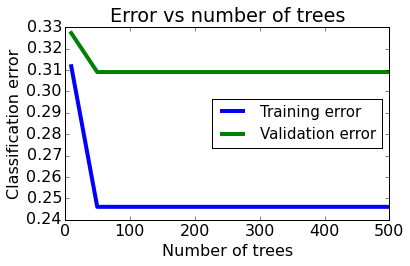

In [37]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')